In [1]:
# imports
import pandas as pd
import numpy as np 

from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
torch.manual_seed(88)

In [2]:
df_train = pd.read_pickle("feature_engineering_train_dataset.pkl")
df_valid = pd.read_pickle("feature_engineering_validation_dataset.pkl")

In [3]:
display(df_train.head(3))
print("Shape: ", df_train.shape)

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wcovid_vaccinated_or_accept,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,...,dummy_south_dakota,dummy_tennessee,dummy_texas,dummy_utah,dummy_vermont,dummy_virginia,dummy_washington,dummy_west_virginia,dummy_wisconsin,dummy_wyoming
0,2021-01-12,10001,27.626437,29.695810,2.245193,61.460460,59.611104,28.867446,45.176114,37.305956,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-13,10001,29.008665,26.041461,2.355360,64.432266,56.863993,29.842478,45.557870,39.091765,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-14,10001,29.180034,26.490986,1.905282,68.381496,64.845904,34.533212,47.707745,37.870228,...,0,0,0,0,0,0,0,0,0,0


Shape:  (8038, 105)


In [4]:
display(df_valid.head(3))
print("Shape: ", df_valid.shape)

,time_value,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wcovid_vaccinated_or_accept,smoothed_wworried_become_ill,smoothed_wvaccine_likely_govt_health,smoothed_wshop_1d,smoothed_wwork_outside_home_1d,...,dummy_south_dakota,dummy_tennessee,dummy_texas,dummy_utah,dummy_vermont,dummy_virginia,dummy_washington,dummy_west_virginia,dummy_wisconsin,dummy_wyoming
0,2021-02-02,10001,32.242002,16.735176,3.854930,65.747872,67.494766,22.045415,66.438259,44.750377,...,0,0,0,0,0,0,0,0,0,0
1,2021-02-03,10001,34.991057,18.797872,9.298927,66.752089,64.805847,26.106294,63.255370,46.075447,...,0,0,0,0,0,0,0,0,0,0
2,2021-02-04,10001,31.996321,17.816678,8.826546,69.706913,64.414916,26.765270,63.628774,46.781418,...,0,0,0,0,0,0,0,0,0,0


Shape:  (1717, 105)


In [5]:
target_var = 'smoothed_wcovid_vaccinated'
list_features = [col for col in df_train.columns if col not in ["time_value",'geo_value','state','county_name'
                                                                ,'day_of_week','day','week_of_month',target_var]]

In [6]:
X_train = torch.tensor(df_train[list_features].values, dtype=torch.float32)
y_train = torch.tensor(df_train[target_var], dtype=torch.float32).view(-1, 1)

X_val = torch.tensor(df_valid[list_features].values, dtype=torch.float32)
y_val = torch.tensor(df_valid[target_var], dtype=torch.float32).view(-1, 1)

In [7]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

In [8]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=64)

In [9]:
def train_one_epoch(model, train_loader, loss_function, optimizer, device):
    """
    Train the model for one epoch
 
    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model to train
    train_loader : torch.utils.data.DataLoader
        DataLoader containing the training data
    loss_function : torch.nn.Module
        Loss function to use for optimization
    optimizer : torch.optim.Optimizer
        Optimizer for updating model parameters
    device : torch.device
        Device to run the training on (CPU or GPU or MPS)
        
    Returns:
    --------
    tuple
        (average_loss, accuracy) for the epoch  
    """    
    # Hint 1: for getting the prediction of the label, check out argmax 
    # function https://pytorch.org/docs/stable/torch.html#reduction-ops

    # Hint 2: If you run into an error when training, print out the dimensions
    # of the output of your neural network and your labels! 

    # (1) SET THE MODEL TO TRAIN
    model.train()

    # initialize variables to collect the loss and accuracy
    running_loss = 0.0
    running_squared_error = 0

    for inputs, targets in train_loader:

        # (2) Move data to device and ensure targets are the correct shape
        inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
       
        # (3) Zero the gradients
        optimizer.zero_grad()
       
        # (4) Forward pass
        outputs = model(inputs)
       
        # (5) Calculate loss
        loss = loss_function(outputs, targets)
       
        # (6) Backward pass and take an optimization step
        loss.backward()
        optimizer.step()

        # (7) Calculate the accuracy over the batch
        running_loss += loss.item() * inputs.size(0)
        running_squared_error += ((outputs - targets) ** 2).sum().item()

    # (8) calculate the loss and accuracy over the epoch using our trackers
    epoch_mse = running_squared_error / len(train_loader.dataset)
    epoch_rmse = epoch_mse ** 0.5
    
    return epoch_rmse

In [10]:
def evaluate(model, valid_loader, device):
    """
    Evaluate the model on the test dataset
    
    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model to evaluate
    test_loader : torch.utils.data.DataLoader
        DataLoader containing the test data
    loss_function : torch.nn.Module
        Loss function to compute the model's performance
    device : torch.device
        Device to run the evaluation on (CPU or GPU or MPS)
        
    Returns:
    --------
    tuple
        (test_loss, test_accuracy) 
    """

    # (1) Set the model to evaluate
    model.eval()
    
    # instantiate variables to collect loss/number of correct items
    all_preds = []
    all_targets = []
    
    # (2) use the `no_grad` context-manager to turn off gradient computation, 
    #      which will speed up inference
    with torch.no_grad():
        for inputs, targets in valid_loader:

            # (3) Move data to device and ensure targets are the correct shape
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)

            # (4) Forward pass
            outputs = model(inputs)
        
            # (5) Calculate loss
            all_preds.append(outputs.cpu())
            all_targets.append(targets.cpu())

    # (8) calculate the loss and accuracy over the epoch using our trackers
    y_pred = torch.cat(all_preds).numpy().flatten()
    y_true = torch.cat(all_targets).numpy().flatten()
    rmse = root_mean_squared_error(y_true, y_pred)
    
    return rmse

In [11]:
def plot_rmse(train_rmses, val_rmses):
    """
    Plot training and validation RMSE over epochs.

    Parameters:
    -----------
    train_rmses : list of float
        Training RMSE for each epoch
    val_rmses : list of float
        Validation RMSE for each epoch
    """
    plt.figure(figsize=(6, 4))
    plt.plot(train_rmses, label='Train RMSE', marker='o')
    plt.plot(val_rmses, label='Validation RMSE', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [12]:
class MLPRegressor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

In [13]:
# (1) Instantiate the MLP
input_size = df_train[list_features].shape[1]
mlp = MLPRegressor(input_size=input_size)
# (2) Instantiate Adam with a learning rate of 0.001
optimizer = optim.Adam(mlp.parameters(), lr=0.001, weight_decay=1e-4)
# (3) Instantiate the Cross Entropy loss function
criterion = nn.MSELoss()

# collect the training/test losses/accuracies
train_rmses = []
val_rmses = []

# we will train for 10 epochs only
num_epochs = 500
# if whatever you are running on has gpu support, this will automatically detect it
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# cpu may actually be faster for these small batch sizes/simple networks-you can test it out yourself
device = 'cpu' 

# (4) send the model to the device
mlp.to(device)
best_rmse = float('inf')
best_model_state = None
best_epoch = -1

# run the training loop
print(f"Training for {num_epochs} epochs on {device}:")
for epoch in range(num_epochs):

    # (5) train one epoch, get `train_loss, train_accuracy` 
    train_rmse = train_one_epoch(mlp, train_loader, criterion, optimizer, device)

    # (6) evaluate on the test set, get `tst_loss, test_accuraacy`
    val_rmse = evaluate(mlp, val_loader, device)

    # (7) append the losses/accuracies to our lists
    train_rmses.append(train_rmse)
    val_rmses.append(val_rmse)
    
    # Track the best validation RMSE
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_state = mlp.state_dict()
        best_epoch = epoch

    print(f"Epoch {epoch+1}/{num_epochs}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")

Training for 500 epochs on cpu:
Epoch 1/500, Train RMSE: 4.7791, Val RMSE: 8.0014
Epoch 2/500, Train RMSE: 4.1047, Val RMSE: 7.2974
Epoch 3/500, Train RMSE: 3.7404, Val RMSE: 5.4152
Epoch 4/500, Train RMSE: 3.2737, Val RMSE: 3.8535
Epoch 5/500, Train RMSE: 2.7255, Val RMSE: 3.1099
Epoch 6/500, Train RMSE: 2.1928, Val RMSE: 2.8822
Epoch 7/500, Train RMSE: 1.9545, Val RMSE: 2.8039
Epoch 8/500, Train RMSE: 1.8738, Val RMSE: 2.5862
Epoch 9/500, Train RMSE: 1.8191, Val RMSE: 2.4471
Epoch 10/500, Train RMSE: 1.7726, Val RMSE: 2.3889
Epoch 11/500, Train RMSE: 1.7397, Val RMSE: 2.3633
Epoch 12/500, Train RMSE: 1.7160, Val RMSE: 2.3403
Epoch 13/500, Train RMSE: 1.6950, Val RMSE: 2.3137
Epoch 14/500, Train RMSE: 1.6777, Val RMSE: 2.3099
Epoch 15/500, Train RMSE: 1.6663, Val RMSE: 2.2949
Epoch 16/500, Train RMSE: 1.6517, Val RMSE: 2.2777
Epoch 17/500, Train RMSE: 1.6395, Val RMSE: 2.2567
Epoch 18/500, Train RMSE: 1.6287, Val RMSE: 2.2313
Epoch 19/500, Train RMSE: 1.6169, Val RMSE: 2.2072
Epoch 20

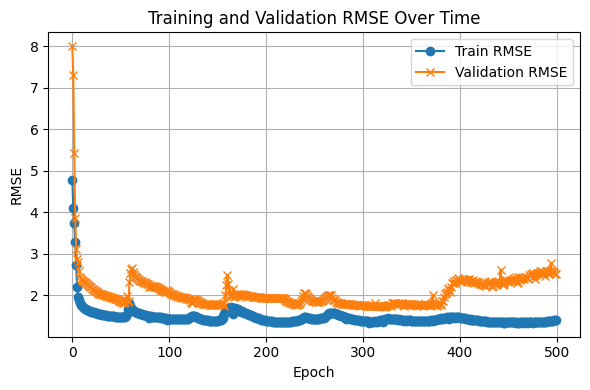

In [14]:
plot_rmse(train_rmses, val_rmses)

In [15]:
# Save best model checkpoint
torch.save(best_model_state, 'best_mlp_model.pth')
print(f"Saved best model from epoch {best_epoch+1} with Train RMSE: {train_rmses[best_epoch+1]:.4f} and Validation RMSE: {best_rmse:.4f}")

Saved best model from epoch 324 with Train RMSE: 1.4234 and Validation RMSE: 1.7221


In [16]:
# 1. Create input tensor
X_train_tensor = torch.tensor(df_train[list_features].values, dtype=torch.float32)

# 2. Load model with correct input size
model = MLPRegressor(input_size=len(list_features))
model.load_state_dict(torch.load("best_mlp_model.pth"))
model.eval()

# 3. Predict
with torch.no_grad():
    y_pred_train_tensor = model(X_train_tensor)
    y_pred_train = y_pred_train_tensor.numpy().flatten()

C:\Users\Asus\AppData\Local\Temp\ipykernel_10908\3900900061.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mlp_model.pth"))


In [17]:
from sklearn.metrics import root_mean_squared_error

train_rmse = root_mean_squared_error(df_train[target_var].values, y_pred_train)
print(f"Train RMSE: {train_rmse:.4f}")

Train RMSE: 1.9891


In [18]:
X_val_tensor = torch.tensor(df_valid[list_features].values, dtype=torch.float32)

model = MLPRegressor(input_size=len(list_features))
model.load_state_dict(torch.load("best_mlp_model.pth"))
model.eval()

with torch.no_grad():
    y_pred_tensor = model(X_val_tensor)
    y_pred = y_pred_tensor.numpy().flatten()

C:\Users\Asus\AppData\Local\Temp\ipykernel_10908\3381789055.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mlp_model.pth"))


In [19]:
rmse = root_mean_squared_error(df_valid[target_var].values, y_pred)
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 2.5038


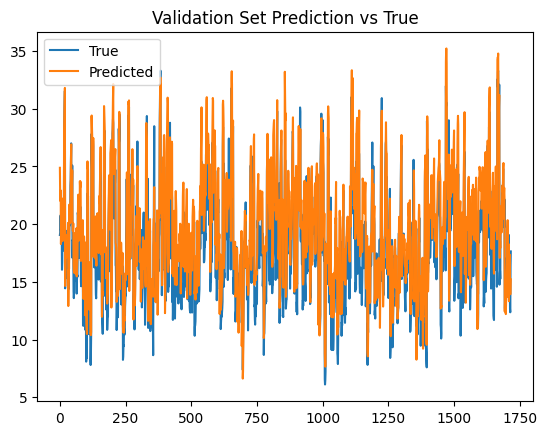

In [20]:
plt.plot(df_valid[target_var].values, label="True")
plt.plot(y_pred, label="Predicted")
plt.title("Validation Set Prediction vs True")
plt.legend()
plt.show()

In [21]:
df_test = pd.read_pickle("feature_engineering_test_dataset.pkl")
X_test_tensor = torch.tensor(df_test[list_features].values, dtype=torch.float32)

model = MLPRegressor(input_size=len(list_features))
model.load_state_dict(torch.load("best_mlp_model.pth"))
model.eval()

with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().flatten()

rmse = root_mean_squared_error(df_test[target_var].values, y_pred)
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 2.6173


C:\Users\Asus\AppData\Local\Temp\ipykernel_10908\2369224689.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mlp_model.pth"))
